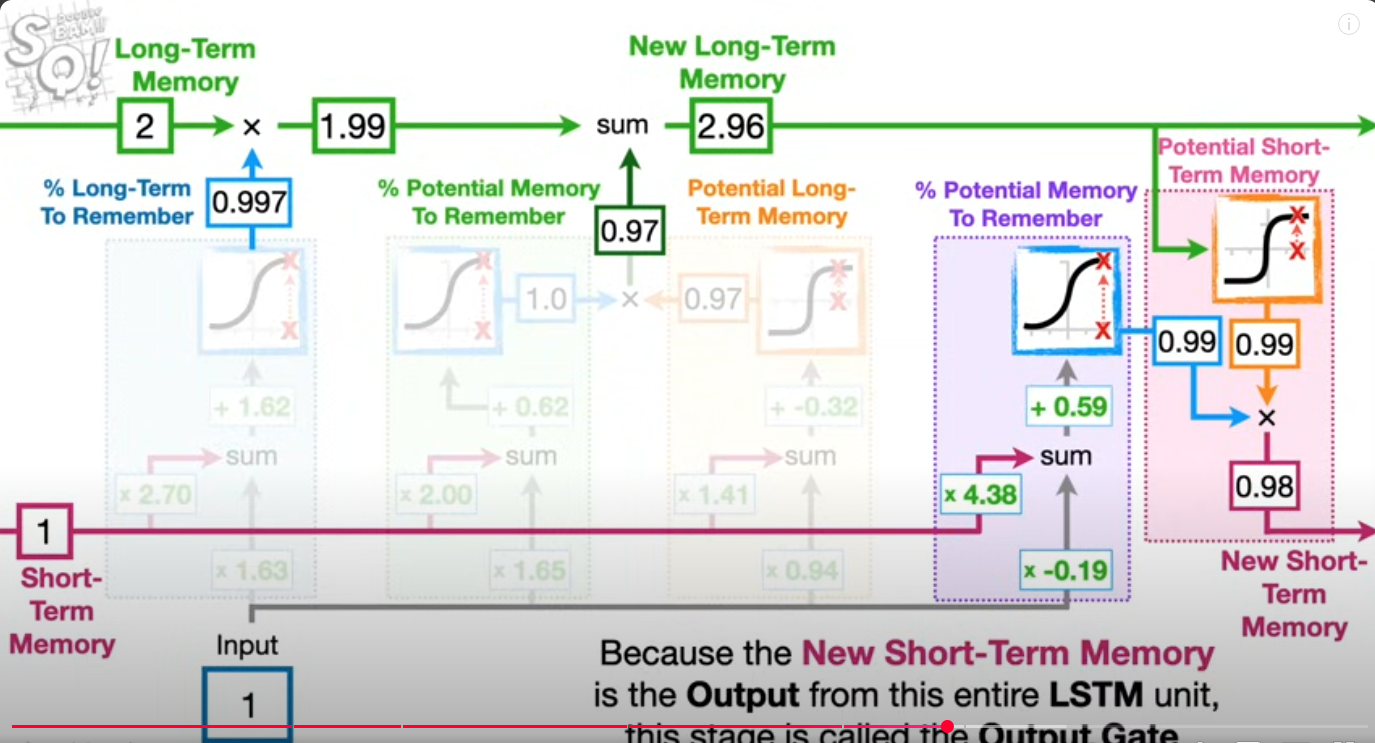

In [1]:
import torch.nn as nn
import numpy as np
import torch
import os
import pandas as pd

device = "mps"

In [2]:
current_dir = os.getcwd()
df_dir = os.path.join(current_dir, "beer.csv")
print(df_dir)

/Users/shounakacharya/Documents/LSTM_dev/beer.csv


In [3]:
dataset = pd.read_csv(df_dir)
dataset.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [4]:
def preprocess(dataset):
    df = dataset.copy()
    split_cols = df['Month'].str.split('-', expand=True)
    df['Year'] = split_cols[0].astype(int)
    df['Month'] = split_cols[1].astype(int)

    df = df[['Year','Month','Monthly beer production']]
    
    n = int(len(df) * 0.75)
    data = {
        'train': df[:n],
        'test': df[n:]
    }

    return data

In [5]:
data = preprocess(dataset)
data['train'].head()

,Year,Month,Monthly beer production
0,1956,1,93.2
1,1956,2,96.0
2,1956,3,95.2
3,1956,4,77.1
4,1956,5,70.9


In [6]:
class RMSEloss(nn.Module):
    def __init__(self, eps = 1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true) + self.eps)

In [7]:
class Forget_Gate(nn.Module):

    def __init__(self,input_size, hidden_size):
        super().__init__()
        self.x_input = nn.Linear(input_size, hidden_size)
        self.stm_input = nn.Linear(hidden_size, hidden_size)
        self.final = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Sigmoid()
        )

    def forward(self, x, stm):
        x = self.x_input(x)
        stm = self.stm_input(stm)
        output = x + stm
        output = self.final(output)

        return output
    

class Update_Gate(nn.Module):

    def __init__(self,input_size, hidden_size):
        super().__init__()
        self.x_input_retain_block = nn.Linear(input_size, hidden_size)
        self.stm_input_retain_block = nn.Linear(hidden_size, hidden_size)
        self.final_retain_block = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Sigmoid()
        )

        self.x_input_pred_block = nn.Linear(input_size, hidden_size)
        self.stm_input_pred_block = nn.Linear(hidden_size, hidden_size)
        self.final_pred_block = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh()
        )

    def forward(self, x, stm):
        
        x_retain = self.x_input_retain_block(x)
        stm_retain = self.stm_input_retain_block(stm)
        x_retain = x_retain + stm_retain
        retain_wei = self.final_retain_block(x_retain)

        x_pred = self.x_input_pred_block(x)
        stm_pred = self.stm_input_pred_block(stm)
        x_pred = x_pred + stm_pred
        pred = self.final_pred_block(x_pred)

        ltm_pred = retain_wei * pred

        return ltm_pred
    
    
class Output_Gate(nn.Module):
    
    def __init__(self, input_size, hidden_size):
        super().__init__()
        
        self.x_input_retain_block = nn.Linear(input_size, hidden_size)
        self.stm_input_retain_block = nn.Linear(hidden_size, hidden_size)
        self.final_retain_block = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Sigmoid()
        )
        
        self.stm_pred_block = nn.Tanh()

    def forward(self,x,stm,ltm):

        x_retain = self.x_input_retain_block(x)
        stm_retain = self.stm_input_retain_block(stm)
        x_retain = x_retain + stm_retain
        retain_wei = self.final_retain_block(x_retain)

        stm_pred = self.stm_pred_block(ltm)
        stm_pred = stm_pred * retain_wei

        return stm_pred
    
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, batch_size = 1, num_layers = 1, dropout = 0.0):
        super().__init__()
        self.num_layers = num_layers
        self.dropout = nn.Dropout(dropout)
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size

        self.layers = nn.ModuleList()

        for layer in range(num_layers):

            layer_input_size = input_size if layer == 0 else hidden_size
            self.layers.append(
                nn.ModuleDict({
                'forget_gate': Forget_Gate(layer_input_size, hidden_size),
                'update_gate': Update_Gate(layer_input_size, hidden_size),
                'output_gate': Output_Gate(layer_input_size, hidden_size)
            }))

        self.prediction = nn.Linear(hidden_size, output_size)

    def forward(self, x_t, hidden = None):
        
        if hidden is None:
            stm = [torch.zeros(self.batch_size, self.hidden_size, device = device) for _ in range(self.num_layers)]
            ltm = [torch.zeros(self.batch_size, self.hidden_size, device = device) for _ in range(self.num_layers)]

        else:
            stm, ltm = hidden

        layer_input = x_t
        new_stm = []
        new_ltm = []

        for layer in range(self.num_layers):
            
            forget = self.layers[layer]['forget_gate']
            update = self.layers[layer]['update_gate']
            output = self.layers[layer]['output_gate']


            ltm_forget_wei = forget(layer_input, stm[layer])
            ltm[layer] = ltm[layer] * ltm_forget_wei

            ltm_update_bias = update(layer_input, stm[layer])
            ltm[layer] = ltm[layer] + ltm_update_bias

            stm[layer] = output(layer_input, stm[layer], ltm[layer])

            if layer < self.num_layers - 1 and self.training:
                layer_input = self.dropout(stm[layer])

            else:
                layer_input = stm[layer]

            new_stm.append(stm[layer])
            new_ltm.append(ltm[layer])

        output = self.prediction(new_stm[-1])

        return output, (new_stm, new_ltm)

    def evaluate(self, x):
        
        # x = (batch_size, seq_len, input_size)
        
        seq_len = x.size(1)       
        outputs = []

        hidden = None

        for t in range(seq_len):

            x_t = x[:, t, :]
            output,hidden = self.forward(x_t, hidden)
            
            outputs.append(output)
            
        outputs = torch.stack(outputs, dim=1)

        return outputs

In [8]:
input_size = 2
hidden_size = 10
output_size = 1
batch_size = 1
num_layers = 1
dropout = 0.0
learning_rate = 0.01

In [9]:
model = LSTM(input_size, hidden_size, output_size, batch_size, num_layers, dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
def get_batch(type = "train", batch_size = batch_size):
    
    batch_df = data[type]
    batch_df_n = len(batch_df)
    index = torch.randint(0, batch_df_n - batch_size+1).item()

    batch = batch_df.iloc[index:index + batch_size]

    y = batch.iloc[:,-1].values
    x = batch.iloc[:,:-1].values


    return torch.tensor(x, dtype = torch.float32, device = device), torch.tensor(y, dtype = torch.float32, device = device)


In [11]:
@torch.no_grad()
def calculate_loss():

    model.eval()

    x,y = get_batch()
    y_pred = model.evaluate(x)
    criterion = RMSEloss()
    loss = criterion(y_pred, y)
    loss = loss.mean()
    
    model.train()
    
    return loss.item()